# Matching up all Argo float porfile with Ox and T/S to Ml CHla and Bbp output

This notebook is a generalization of the workflow from 3d_products.ipynb

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from argopy import ArgoFloat


dat = xr.open_dataset("../Data/Raw/cmems_obs-mob_glo_bgc-chl-poc_my_0.25deg_P7D-m_multi-vars_39.88W-10.12W_58.12N-64.88N_0.00-200.00m_2015-01-07-2023-12-27.nc")

In [2]:
argo_df = pd.read_csv("../Data/Processed/ts_floats_to_match.csv")

In [3]:
argo_df

,float_wmo,prof_number,lon,lat,date,depth,temp,sal
0,1901210,166,-38.136000,58.003000,2016-02-13,0,3.944000,34.897999
1,1901210,166,-38.136000,58.003000,2016-02-13,1,3.948000,34.893499
2,1901210,166,-38.136000,58.003000,2016-02-13,2,3.952000,34.889000
3,1901210,166,-38.136000,58.003000,2016-02-13,3,3.953000,34.889000
4,1901210,166,-38.136000,58.003000,2016-02-13,4,3.954000,34.889000
...,...,...,...,...,...,...,...,...
775453,7902223,52,-30.606907,61.084361,2025-10-27,196,7.438904,35.096630
775454,7902223,52,-30.606907,61.084361,2025-10-27,197,7.434623,35.097805
775455,7902223,52,-30.606907,61.084361,2025-10-27,198,7.421692,35.096729
775456,7902223,52,-30.606907,61.084361,2025-10-27,199,7.412808,35.095915


In [4]:
# Bin argo_df by 5m depth intervals per profile (unique float_wmo and prof_number)
# Create depth bins
argo_df['depth_bin'] = (argo_df['depth'] / 5).round().astype(int) * 5

# Group by float_wmo, prof_number, and depth_bin, then aggregate
argo_binned = argo_df.groupby(['float_wmo', 'prof_number', 'depth_bin']).agg({
    'lon': 'first',
    'lat': 'first',
    'date': 'first',  # Assuming date is unique per profile
    'temp': 'median',
    'sal': 'median',
    'depth': 'median'
}).reset_index()


In [5]:
argo_binned

,float_wmo,prof_number,depth_bin,lon,lat,date,temp,sal,depth
0,1901210,166,0,-38.136000,58.003000,2016-02-13,3.948000,34.893499,1.0
1,1901210,166,5,-38.136000,58.003000,2016-02-13,3.955000,34.889000,5.0
2,1901210,166,10,-38.136000,58.003000,2016-02-13,3.959000,34.889000,10.0
3,1901210,166,15,-38.136000,58.003000,2016-02-13,3.961000,34.889666,15.0
4,1901210,166,20,-38.136000,58.003000,2016-02-13,3.964000,34.889000,20.0
...,...,...,...,...,...,...,...,...,...
158173,7902223,52,180,-30.606907,61.084361,2025-10-27,7.481476,35.087460,180.0
158174,7902223,52,185,-30.606907,61.084361,2025-10-27,7.468106,35.088074,185.0
158175,7902223,52,190,-30.606907,61.084361,2025-10-27,7.448348,35.091005,190.0
158176,7902223,52,195,-30.606907,61.084361,2025-10-27,7.436223,35.095930,195.0


In [6]:

argo_xr = xr.Dataset(
    data_vars={
        "temp": ("obs", argo_binned["temp"].values),
        "sal": ("obs", argo_binned["sal"].values),
    },
    coords={
        "obs": np.arange(len(argo_binned)),
        "profile_id": ("obs", argo_binned["float_wmo"].astype(str) + "_" + argo_binned["prof_number"].astype(str)),
        "longitude": ("obs", argo_binned["lon"].values),
        "latitude": ("obs", argo_binned["lat"].values),
        "date": ("obs", argo_binned["date"].values),
        "depth": ("obs", argo_binned["depth_bin"].values),
        "float_wmo": ("obs", argo_binned["float_wmo"].values),
        "prof_number": ("obs", argo_binned["prof_number"].values)
    }
)

In [7]:
argo_binned["profile_id"] = (
    argo_binned["float_wmo"].astype(str)
    + "_"
    + argo_binned["prof_number"].astype(str)
)


In [8]:
argo_xr = (
    argo_binned
    .set_index(["profile_id", "depth_bin"])
    .sort_index()
    .to_xarray()
)

In [9]:
argo_xr = argo_xr.set_coords(['lon', 'lat', 'date', 'depth', 'float_wmo', 'prof_number'])

In [10]:

argo_xr["CHLA_ML"] = dat["chl"].sel(
    longitude=argo_xr["lon"], 
    latitude=argo_xr["lat"], 
    time=argo_xr["date"], 
    depth=argo_xr['depth'],
    method="nearest"
)


argo_xr["BBP700_ML"] = dat["bbp"].sel(
    longitude=argo_xr["lon"], 
    latitude=argo_xr["lat"], 
    time=argo_xr["date"], 
    depth=argo_xr['depth'],
    method="nearest"
)


argo_xr["PAR"] = dat["PAR"].sel(
    longitude=argo_xr["lon"], 
    latitude=argo_xr["lat"], 
    time=argo_xr["date"], 
    depth=argo_xr['depth'],
    method="nearest"
)

In [11]:
argo_xr

<xarray.Dataset> Size: 15MB
Dimensions:      (profile_id: 3858, depth_bin: 41)
Coordinates:
    float_wmo    (profile_id, depth_bin) int64 1MB 1901210 1901210 ... 7902223
    prof_number  (profile_id, depth_bin) int64 1MB 166 166 166 166 ... 9 9 9 9
    lon          (profile_id, depth_bin) float64 1MB -38.14 -38.14 ... -19.96
    lat          (profile_id, depth_bin) float64 1MB 58.0 58.0 ... 62.33 62.33
    date         (profile_id, depth_bin) object 1MB '2016-02-13' ... '2024-09...
    depth        (profile_id, depth_bin) float64 1MB 1.0 5.0 ... 195.0 199.0
  * profile_id   (profile_id) object 31kB '1901210_166' ... '7902223_9'
  * depth_bin    (depth_bin) int64 328B 0 5 10 15 20 25 ... 180 185 190 195 200
    latitude     (profile_id, depth_bin) float32 633kB 58.12 58.12 ... 62.38
    longitude    (profile_id, depth_bin) float32 633kB -38.12 -38.12 ... -19.88
    time         (profile_id, depth_bin) datetime64[ns] 1MB 2016-02-10 ... 20...
Data variables:
    temp         (profile_id, depth_bin) float64 1MB 3.948 3.955 ... 8.871 8.864
    sal          (profile_id, depth_bin) float64 1MB 34.89 34.89 ... 35.27 35.27
    CHLA_ML      (profile_id, depth_bin) float32 633kB ...
    BBP700_ML    (profile_id, depth_bin) float32 633kB ...
    PAR          (profile_id, depth_bin) float32 633kB ...

In [12]:
df = argo_xr.to_dataframe().reset_index(drop=True)

df["profile_id"] = (
    df["float_wmo"].astype(str)
    + "_"
    + df["prof_number"].astype(str)
)


In [13]:
df

,float_wmo,prof_number,lon,lat,date,temp,sal,depth,latitude,longitude,time,CHLA_ML,BBP700_ML,PAR,profile_id
0,1901210,166,-38.136000,58.003000,2016-02-13,3.948000,34.893499,1.0,58.125,-38.125,2016-02-10,NaN,NaN,NaN,1901210_166
1,1901210,166,-38.136000,58.003000,2016-02-13,3.955000,34.889000,5.0,58.125,-38.125,2016-02-10,NaN,NaN,NaN,1901210_166
2,1901210,166,-38.136000,58.003000,2016-02-13,3.959000,34.889000,10.0,58.125,-38.125,2016-02-10,NaN,NaN,NaN,1901210_166
3,1901210,166,-38.136000,58.003000,2016-02-13,3.961000,34.889666,15.0,58.125,-38.125,2016-02-10,NaN,NaN,NaN,1901210_166
4,1901210,166,-38.136000,58.003000,2016-02-13,3.964000,34.889000,20.0,58.125,-38.125,2016-02-10,NaN,NaN,NaN,1901210_166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158173,7902223,9,-19.961777,62.327156,2024-09-10,8.938033,35.276440,180.0,62.375,-19.875,2023-12-27,NaN,NaN,NaN,7902223_9
158174,7902223,9,-19.961777,62.327156,2024-09-10,8.919509,35.275019,185.0,62.375,-19.875,2023-12-27,NaN,NaN,NaN,7902223_9
158175,7902223,9,-19.961777,62.327156,2024-09-10,8.893389,35.273998,190.0,62.375,-19.875,2023-12-27,NaN,NaN,NaN,7902223_9
158176,7902223,9,-19.961777,62.327156,2024-09-10,8.870595,35.272999,195.0,62.375,-19.875,2023-12-27,NaN,NaN,NaN,7902223_9


In [14]:
# Define the new depth range from 0 to 200 meters
new_depths = np.arange(0, 200, 1)  # 1m resolution

# Function to interpolate for each profile
def interpolate_profile(group):
    # Sort by STD_PRES_BINS
    group = group.sort_values('depth')
    
    # Create interpolation functions for each variable, skipping NaNs
    interp_funcs = {}
    for col in ['CHLA_ML', 'BBP700_ML', 'PAR', 'temp', 'sal']:
        if group[col].notna().any():
            # Use linear interpolation, fill NaNs with interpolated values
            interp_funcs[col] = np.interp(new_depths, group['depth'], group[col], left=np.nan, right=np.nan)
        else:
            interp_funcs[col] = np.full(len(new_depths), np.nan)
    
    # Create new dataframe for this profile
    new_df = pd.DataFrame({
        'profile_id': group['profile_id'].iloc[0],
        'date': group['date'].iloc[0],
        'PRES': new_depths,
        'latitude': group['lat'].iloc[0],
        'longitude': group['lon'].iloc[0],
        'CHLA_ML': interp_funcs['CHLA_ML'],
        'BBP700_ML': interp_funcs['BBP700_ML'],
        'PAR': interp_funcs['PAR'],
        'temperature': interp_funcs['temp'],
        'salinity': interp_funcs['sal']
    })
    
    return new_df

# Apply interpolation to each profile
interpolated_df = df.groupby('profile_id').apply(interpolate_profile).reset_index(drop=True)
interpolated_df["date"] = pd.to_datetime(interpolated_df["date"])
# Display the new dataframe
interpolated_df

C:\Users\petit\AppData\Local\Temp\ipykernel_3136\22668448.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interpolated_df = df.groupby('profile_id').apply(interpolate_profile).reset_index(drop=True)


,profile_id,date,PRES,latitude,longitude,CHLA_ML,BBP700_ML,PAR,temperature,salinity
0,1901210_166,2016-02-13,0,58.003000,-38.136000,NaN,NaN,NaN,NaN,NaN
1,1901210_166,2016-02-13,1,58.003000,-38.136000,NaN,NaN,NaN,3.948000,34.893499
2,1901210_166,2016-02-13,2,58.003000,-38.136000,NaN,NaN,NaN,3.949750,34.892375
3,1901210_166,2016-02-13,3,58.003000,-38.136000,NaN,NaN,NaN,3.951500,34.891250
4,1901210_166,2016-02-13,4,58.003000,-38.136000,NaN,NaN,NaN,3.953250,34.890125
...,...,...,...,...,...,...,...,...,...,...
771595,7902223_9,2024-09-10,195,62.327156,-19.961777,NaN,NaN,NaN,8.870595,35.272999
771596,7902223_9,2024-09-10,196,62.327156,-19.961777,NaN,NaN,NaN,8.869004,35.272749
771597,7902223_9,2024-09-10,197,62.327156,-19.961777,NaN,NaN,NaN,8.867412,35.272499
771598,7902223_9,2024-09-10,198,62.327156,-19.961777,NaN,NaN,NaN,8.865820,35.272249


In [15]:
from cbpm_py import cbpm_argo

C:\Users\petit\AppData\Local\Temp\ipykernel_3136\2089884263.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


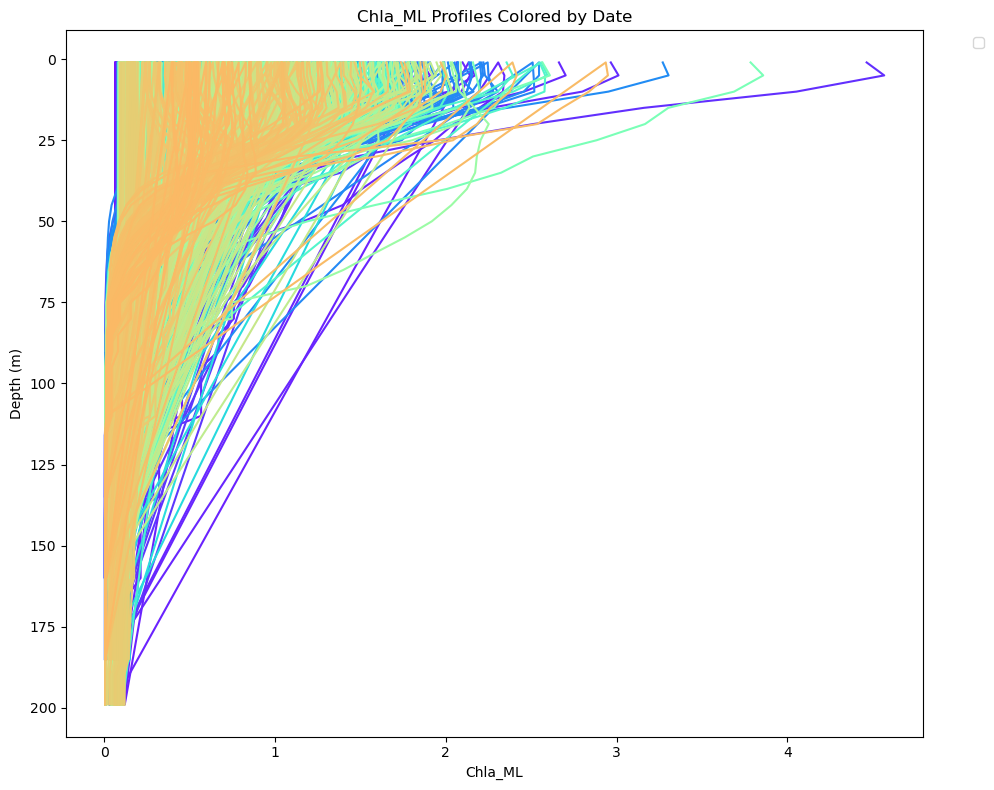

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get unique dates and sort them
unique_dates = sorted(interpolated_df['date'].unique())

# Create a rainbow colormap
cmap = plt.get_cmap('rainbow')
norm = mcolors.Normalize(vmin=0, vmax=len(unique_dates)-1)

fig, ax = plt.subplots(figsize=(10, 8))

for i, date in enumerate(unique_dates):
    profile_data = interpolated_df[interpolated_df['date'] == date].dropna(subset=['CHLA_ML'])
    if not profile_data.empty:
        ax.plot(profile_data['CHLA_ML'], profile_data['PRES'], color=cmap(norm(i)))

ax.set_xlabel('Chla_ML')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.set_title('Chla_ML Profiles Colored by Date')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\petit\AppData\Local\Temp\ipykernel_3136\364959738.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


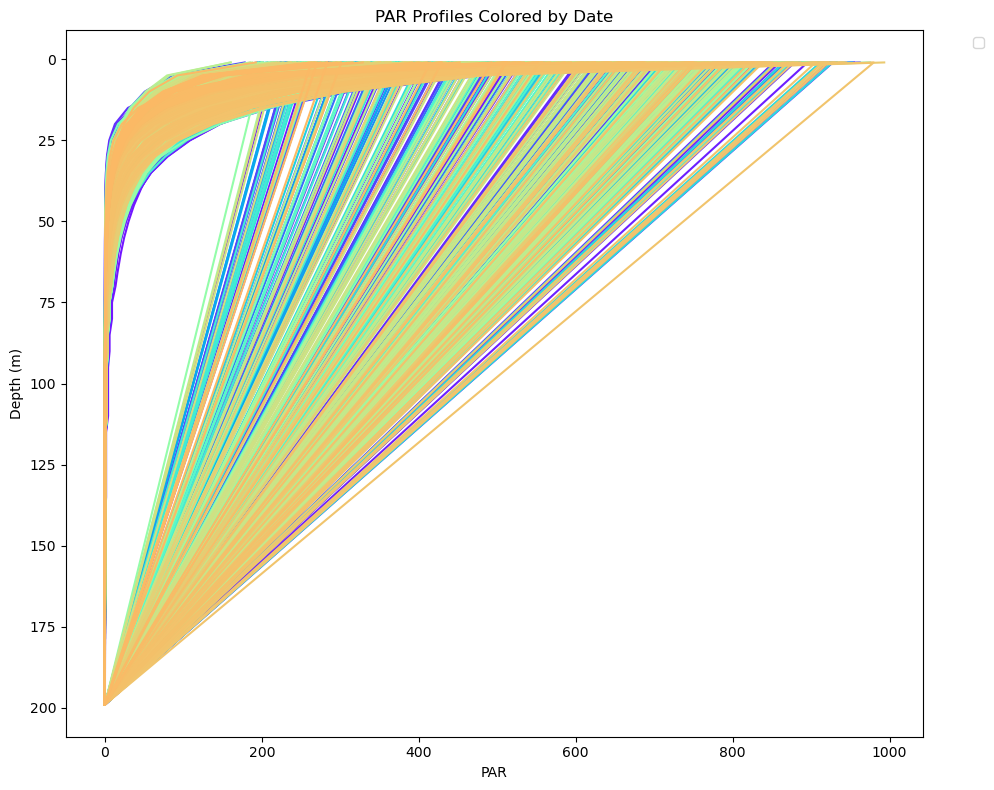

In [17]:
# Get unique dates and sort them
unique_dates = sorted(interpolated_df['date'].unique())

# Create a rainbow colormap
cmap = plt.get_cmap('rainbow')
norm = mcolors.Normalize(vmin=0, vmax=len(unique_dates)-1)

fig, ax = plt.subplots(figsize=(10, 8))

for i, date in enumerate(unique_dates):
    profile_data = interpolated_df[interpolated_df['date'] == date].dropna(subset=['PAR'])
    if not profile_data.empty:
        ax.plot(profile_data['PAR'], profile_data['PRES'], color=cmap(norm(i)))

ax.set_xlabel('PAR')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.set_title('PAR Profiles Colored by Date')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
surface_par_df = interpolated_df[interpolated_df['PRES'] == 1][['date', 'PAR', 'latitude', 'longitude']].reset_index(drop=True)
mask = surface_par_df['PAR'].notna()
surface_par_df = surface_par_df[mask]
surface_par_df

,date,PAR,latitude,longitude
1,2016-03-24,504.182465,58.416000,-39.896000
2,2016-04-13,730.578979,58.500000,-39.202000
3,2016-04-23,742.701782,58.523000,-38.546000
4,2016-05-03,839.603149,58.720000,-39.087000
6,2016-05-23,773.229492,59.273000,-37.629000
...,...,...,...,...
3801,2023-08-03,838.665344,59.363087,-38.028523
3802,2023-08-13,750.136719,58.742210,-37.971777
3803,2023-08-23,664.044312,58.578557,-38.095720
3804,2023-09-02,559.594177,58.485832,-38.591845


In [20]:
import pvlib
surface_par_df = surface_par_df.reset_index(drop=True)

tz = 'UTC'
daily_par = []

for i in range(len(surface_par_df)):
    
    lat, lon = surface_par_df['latitude'][i], surface_par_df['longitude'][i]
    location = pvlib.location.Location(lat, lon, tz)

    # Full day at 1-min resolution
    date = surface_par_df['date'][i].strftime('%Y-%m-%d')
    times = pd.date_range(
        f'{date} 00:00',
        f'{date} 23:59',
        freq='1min',
        tz=tz
    )

    clearsky = location.get_clearsky(times)
    ghi = clearsky['ghi']  # W m-2
    PAR_clear = ghi *4.57 # Convert to µmol photons m-2 s-1

    t_meas = pd.Timestamp(f'{date} 12:00', tz=tz)
    PAR_meas = surface_par_df['PAR'][i]  # example

    PAR_clear_meas = PAR_clear.loc[t_meas]

    scale = PAR_meas / PAR_clear_meas
    PAR_scaled = PAR_clear * scale

    # Convert µmol m-2 s-1 → mol m-2 day-1
    DLI = PAR_scaled.sum() * 60 / 1e6
    daily_par.append(DLI)

surface_par_df['daily_par'] = daily_par

In [21]:
interpolated_df = interpolated_df.merge(surface_par_df[['date', 'daily_par']], on='date', how='left')

In [22]:

# Function to process each profile
def process_profile(group):
    # Sort by PRES
    group = group.sort_values('PRES')
    
    # Check 0-60 PRES for CHLA_ML and BBP700_ML
    mask_0_60 = (group['PRES'] >= 0) & (group['PRES'] <= 60)
    chla_0_60 = group.loc[mask_0_60, 'CHLA_ML']
    bbp_0_60 = group.loc[mask_0_60, 'BBP700_ML']
    
    # Interpolate NaNs in 0-60
    if chla_0_60.isna().any():
        group.loc[mask_0_60, 'CHLA_ML'] = chla_0_60.interpolate(method='linear')
    if bbp_0_60.isna().any():
        group.loc[mask_0_60, 'BBP700_ML'] = bbp_0_60.interpolate(method='linear')
    
    # After interpolation, check if still NaNs in 0-60
    if group.loc[mask_0_60, ['CHLA_ML', 'BBP700_ML']].isna().any().any():
        return None  # Remove profile
    
    # For 60-200, fill NaNs with value at greatest PRES
    mask_60_200 = (group['PRES'] > 60) & (group['PRES'] <= 200)
    max_pres_value_chla = group.loc[group['PRES'] == group['PRES'].max(), 'CHLA_ML'].iloc[0]
    max_pres_value_bbp = group.loc[group['PRES'] == group['PRES'].max(), 'BBP700_ML'].iloc[0]
    
    group.loc[mask_60_200 & group['CHLA_ML'].isna(), 'CHLA_ML'] = max_pres_value_chla
    group.loc[mask_60_200 & group['BBP700_ML'].isna(), 'BBP700_ML'] = max_pres_value_bbp
    
    return group

# Apply to each profile_id
processed_dfs = []
for pid in interpolated_df['profile_id'].unique():
    group = interpolated_df[interpolated_df['profile_id'] == pid]
    processed = process_profile(group)
    if processed is not None:
        processed_dfs.append(processed)

# Concatenate back
interpolated_df = pd.concat(processed_dfs).reset_index(drop=True)

ValueError: No objects to concatenate

In [23]:
interpolated_df['BBP470_ML'] = interpolated_df['BBP700_ML']/(470/400) 
interpolated_df['carbon_ML'] = 12128 * interpolated_df['BBP470_ML'] + 0.59

In [24]:
interpolated_df = interpolated_df.fillna(0)

In [25]:
def opp_befa(chl, irr, sst, dayL):
    if chl < 1.0:
        chl_tot = 38.0 * np.power(chl, 0.425)
    else:
        chl_tot = 40.2 * np.power(chl, 0.507)

    z_eu = 200.0 * np.power(chl_tot, (-0.293))

    if z_eu <= 102.0:
         z_eu = 568.2 * np.power(chl_tot, -0.746)

    if sst < -10.0:
        pb_opt = 0.0
    elif sst < -1.0:
        pb_opt = 1.13
    elif sst > 28.5:
        pb_opt = 4.0
    else:
        pb_opt = 1.2956 + 2.749e-1*sst + 6.17e-2*np.power(sst, 2) - \
            2.05e-2*np.power(sst, 3) + 2.462e-3*np.power(sst, 4) - \
            1.348e-4*np.power(sst, 5) + 3.4132e-6*np.power(sst, 6) - \
            3.27e-8*np.power(sst, 7)

    irrFunc = 0.66125 * irr / (irr + 4.1)

    npp = pb_opt * chl * dayL * irrFunc * z_eu

    return npp

def cal_dayL(lat, yDay):
    gamma = lat/180.0 * np.pi
    psi = yDay/365.0 * 2.0 * np.pi
    solarDec = (0.39637 - 22.9133*np.cos(psi) + 4.02543*np.sin(psi) - \
                0.38720*np.cos(2*psi) + 0.05200*np.sin(2*psi)) * np.pi/180.0
    r = -np.tan(gamma) * np.tan(solarDec)

    if r<=-1:
        return 24.0
    elif np.fabs(r)<1:
        return 24.0 * np.arccos(r) / np.pi
    else:
        return 0
    
def day_of_year(day, month, year=2024):
    return (datetime.date(year, month, day) - datetime.date(year, 1, 1)).days + 1

In [26]:
interpolated_df['year'] = interpolated_df['date'].dt.year
interpolated_df['month'] = interpolated_df['date'].dt.month
interpolated_df['day'] = interpolated_df['date'].dt.day

In [30]:
temp_dftemp_df = temp_df.drop_duplicates(subset=['PRES'])

In [31]:
temp_dftemp_df

,profile_id,date,PRES,latitude,longitude,CHLA_ML,BBP700_ML,PAR,temperature,salinity,daily_par,BBP470_ML,carbon_ML,year,month,day
200,1901210_170,2016-03-24,0,58.416,-39.896,0.000000,0.000000,0.000000,0.000000,0.000000,18.415665,0.000000,0.000000,2016,3,24
203,1901210_170,2016-03-24,1,58.416,-39.896,0.102901,0.000318,504.182465,3.795000,34.893499,18.415665,0.000271,3.873920,2016,3,24
206,1901210_170,2016-03-24,2,58.416,-39.896,0.102857,0.000317,443.638229,3.798250,34.892375,18.415665,0.000270,3.864887,2016,3,24
209,1901210_170,2016-03-24,3,58.416,-39.896,0.102813,0.000316,383.093994,3.801500,34.891250,18.415665,0.000269,3.855853,2016,3,24
212,1901210_170,2016-03-24,4,58.416,-39.896,0.102769,0.000316,322.549759,3.804750,34.890125,18.415665,0.000269,3.846819,2016,3,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,1901210_170,2016-03-24,195,58.416,-39.896,0.062584,0.000299,0.062422,3.704364,34.890999,18.415665,0.000255,3.679275,2016,3,24
788,1901210_170,2016-03-24,196,58.416,-39.896,0.062584,0.000299,0.062422,3.704106,34.890999,18.415665,0.000255,3.679275,2016,3,24
791,1901210_170,2016-03-24,197,58.416,-39.896,0.062584,0.000299,0.062422,3.703848,34.890999,18.415665,0.000255,3.679275,2016,3,24
794,1901210_170,2016-03-24,198,58.416,-39.896,0.062584,0.000299,0.062422,3.703591,34.890999,18.415665,0.000255,3.679275,2016,3,24


In [43]:
import datetime
dfs = []
depth_grid = np.arange(0,200)

# Iterate through each unique profile index
for i in interpolated_df['profile_id'].unique():
    # Filter for rows corresponding to the current 'JULD'
    temp_df = interpolated_df[interpolated_df['profile_id'] == i].copy()  # Use `.copy()` to avoid warnings

    temp_df = temp_df.drop_duplicates(subset=['PRES'])
    # Extract the pressure and chlorophyll values for interpolation
    pres_values = temp_df['PRES'].to_numpy()
    temp_values = temp_df['temperature'].to_numpy()

    #extract ML derived variables
    chl_ML_values = temp_df['CHLA_ML'].to_numpy()
    carbon_ML_values = temp_df['carbon_ML'].to_numpy()

    # # Apply the running mean smoothing
    # chl_smoothed = running_mean(chl_values, window_size=5)
    # carbon_smoothed = running_mean(carbon_values, window_size=5)

    # Check for valid data before interpolation (avoid NaN values)
    mask = ~np.isnan(pres_values) & ~np.isnan(chl_ML_values)
    pres_values = pres_values[mask]
    temp_values = temp_values[mask]

    chl_ML_values = chl_ML_values[mask]
    chl_ML_values[0] = chl_ML_values[1]
    carbon_ML_values = carbon_ML_values[mask]
    carbon_ML_values[0] = carbon_ML_values[1]


    irr = temp_df['daily_par'].mean()  # Mean irradiance value
    year = int(temp_df['year'].mean())
    month = int(temp_df['month'].mean())
    day = int(temp_df['day'].mean())
    lat = temp_df['latitude'].mean()
    temp_values[0] = temp_values[1]
    sst = temp_values[0:5].mean()


    #calculation of daylength
    doy = day_of_year(day, month)
    day_length = cal_dayL(lat, doy)


    size_max = len(temp_df)


    # Call the cbpm_argo function with interpolated data from ML
    [pp_z, mu_z, par_z, prcnt_z, nutTempFunc_z, IgFunc_z, mzeu] = cbpm_argo.cbpm_argo(chl_ML_values, carbon_ML_values, irr, year, month, day, lat)

    #VGPM computation from ML
    npp_vgpm = opp_befa(chl_ML_values[1], irr, sst, day_length)

    temp_df.loc[:, 'pp_ML'] = pp_z[0:size_max]
    temp_df.loc[:, 'npp_vgpm_ML'] = np.full(size_max, npp_vgpm)
    temp_df.loc[:, 'zeu'] = np.full(size_max, mzeu)
    temp_df.loc[:, 'mu'] = mu_z[0:size_max]

    # Append modified DataFrame to the list
    dfs.append(temp_df)


# Combine all DataFrames
final_df = pd.concat(dfs)

c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:128: RuntimeWarning: invalid value encountered in scalar divide
  chlC_z[z] = chl_z[z] / Cphyto_z[z]
c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:139: RuntimeWarning: invalid value encountered in scalar divide
  prcnt_z[z] = par_z[z] / (irr * 0.975)
C:\Users\petit\AppData\Local\Temp\ipykernel_3136\1915964035.py:7: RuntimeWarning: divide by zero encountered in power
  z_eu = 200.0 * np.power(chl_tot, (-0.293))
C:\Users\petit\AppData\Local\Temp\ipykernel_3136\1915964035.py:26: RuntimeWarning: invalid value encountered in scalar multiply
  npp = pb_opt * chl * dayL * irrFunc * z_eu
c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:128: RuntimeWarning: invalid value encountered in scalar divide
  chlC_z[z] = chl_z[z] / Cphyto_z[z]
C:\Users\petit\AppData\Local\Temp\ipykernel_3136\1915964035.py:7: RuntimeWarning: divide by zero encountered in power
  z_eu

In [44]:
final_df

,profile_id,date,PRES,latitude,longitude,CHLA_ML,BBP700_ML,PAR,temperature,salinity,daily_par,BBP470_ML,carbon_ML,year,month,day,pp_ML,npp_vgpm_ML,zeu,mu
0,1901210_166,2016-02-13,0,58.003000,-38.136000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,2016,2,13,NaN,NaN,NaN,NaN
1,1901210_166,2016-02-13,1,58.003000,-38.136000,0.0,0.0,0.0,3.948000,34.893499,0.0,0.0,0.0,2016,2,13,NaN,NaN,NaN,NaN
2,1901210_166,2016-02-13,2,58.003000,-38.136000,0.0,0.0,0.0,3.949750,34.892375,0.0,0.0,0.0,2016,2,13,NaN,NaN,NaN,NaN
3,1901210_166,2016-02-13,3,58.003000,-38.136000,0.0,0.0,0.0,3.951500,34.891250,0.0,0.0,0.0,2016,2,13,NaN,NaN,NaN,NaN
4,1901210_166,2016-02-13,4,58.003000,-38.136000,0.0,0.0,0.0,3.953250,34.890125,0.0,0.0,0.0,2016,2,13,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092795,7902223_9,2024-09-10,195,62.327156,-19.961777,0.0,0.0,0.0,8.870595,35.272999,0.0,0.0,0.0,2024,9,10,NaN,NaN,NaN,NaN
1092796,7902223_9,2024-09-10,196,62.327156,-19.961777,0.0,0.0,0.0,8.869004,35.272749,0.0,0.0,0.0,2024,9,10,NaN,NaN,NaN,NaN
1092797,7902223_9,2024-09-10,197,62.327156,-19.961777,0.0,0.0,0.0,8.867412,35.272499,0.0,0.0,0.0,2024,9,10,NaN,NaN,NaN,NaN
1092798,7902223_9,2024-09-10,198,62.327156,-19.961777,0.0,0.0,0.0,8.865820,35.272249,0.0,0.0,0.0,2024,9,10,NaN,NaN,NaN,NaN


In [45]:
# Create a new dataframe with one row per profile_id
# Integrate pp and pp_ML over depth (sum, assuming 1m depth bins)
# Keep average of npp_vgpm and npp_vgpm_ML (which are constant per profile)

grouped = final_df.groupby('profile_id')

profile_summary_df = grouped.agg({
    'date': 'first',
    'latitude': 'first',
    'longitude': 'first',
    'pp_ML': 'sum',
    'npp_vgpm_ML': 'mean'
})

profile_summary_df

,date,latitude,longitude,pp_ML,npp_vgpm_ML
profile_id,,,,,
1901210_166,2016-02-13,58.003000,-38.136000,0.000000,NaN
1901210_170,2016-03-24,58.416000,-39.896000,341.344588,135.039664
1901210_172,2016-04-13,58.500000,-39.202000,502.134434,246.834853
1901210_173,2016-04-23,58.523000,-38.546000,602.173028,372.761716
1901210_174,2016-05-03,58.720000,-39.087000,846.783927,626.234151
...,...,...,...,...,...
7902223_52,2025-10-27,61.084361,-30.606907,0.000000,NaN
7902223_6,2024-09-07,62.330171,-19.602902,0.000000,NaN
7902223_7,2024-09-08,62.354183,-19.749048,0.000000,NaN


In [51]:
daily_mean = daily_mean[daily_mean['date'] < '2024-01-01']

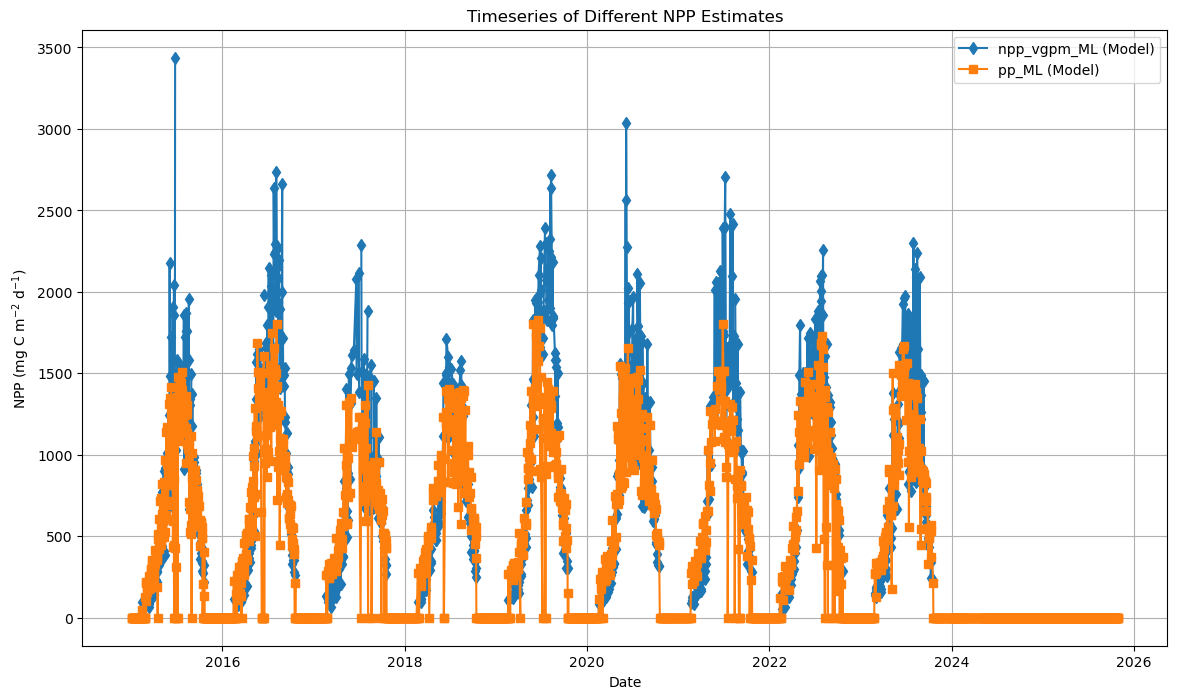

In [52]:
# Aggregate by date
daily_mean = profile_summary_df.groupby('date').mean().reset_index()

plt.figure(figsize=(14, 8))
plt.plot(daily_mean['date'], daily_mean['npp_vgpm_ML'], label='npp_vgpm_ML (Model)', marker='d')
plt.plot(daily_mean['date'], daily_mean['pp_ML'], label='pp_ML (Model)', marker='s')


plt.xlabel('Date')
plt.ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)')
plt.title('Timeseries of Different NPP Estimates')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\petit\AppData\Local\Temp\ipykernel_3136\3151684369.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')


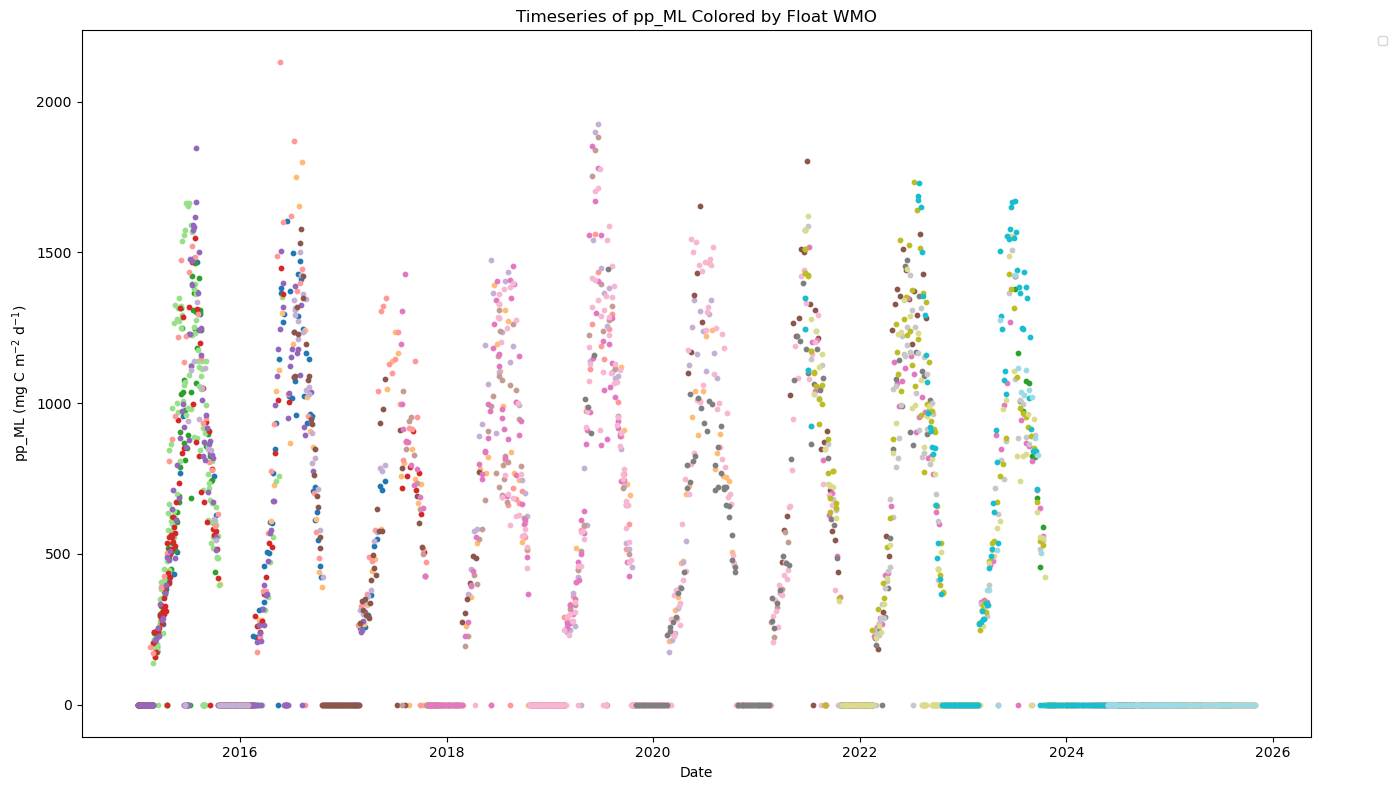

In [56]:
# Extract float_wmo from profile_id
profile_summary_df['float_wmo'] = profile_summary_df.index.str.split('_').str[0]

# Get unique float_wmo for coloring
unique_wmos = sorted(profile_summary_df['float_wmo'].unique())

# Create a colormap
cmap = plt.get_cmap('tab20')  # Use tab20 for distinct colors
norm = mcolors.Normalize(vmin=0, vmax=len(unique_wmos)-1)

fig, ax = plt.subplots(figsize=(14, 8))

for i, wmo in enumerate(unique_wmos):
    wmo_data = profile_summary_df[profile_summary_df['float_wmo'] == wmo]
    ax.scatter(wmo_data['date'], wmo_data['pp_ML'], color=cmap(norm(i)), s=10)

ax.set_xlabel('Date')
ax.set_ylabel('pp_ML (mg C m$^{-2}$ d$^{-1}$)')
ax.set_title('Timeseries of pp_ML Colored by Float WMO')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()